# Data Agumentation

In [1]:
# imports 
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import tensorflow as tf
from collections import Counter
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
import shutil

In [2]:
# Define Paths
dataset_dir = "train_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 3501
Class: Moderate Dementia, Files Found: 342
Class: Non Demented, Files Found: 10500
Class: Very mild Dementia, Files Found: 9607


In [3]:
path_train = "train_dataset"
path_val = "val_dataset"
val_datagenerator = ImageDataGenerator(rescale=1/255.)
train_datagenerator_augmentation = ImageDataGenerator(rescale = 1/255.,
                                                      rotation_range=20, #rotate the image
                                                      zoom_range = 0.2,#zoom the image
                                                      width_shift_range=0.2, #shift the image horizontally
                                                      height_shift_range=0.2, #shift the image vertically
                                                      horizontal_flip=True, #flip the image on horizontal axis
                                                      vertical_flip=True, #flip the image on vertical axis
                                                      shear_range = 0.2) #Shear the image



In [4]:
#Load data in from images and turn into batches
val_data = val_datagenerator.flow_from_directory(path_val,
                                                     target_size=(128,128),
                                                     batch_size=32,
                                                     class_mode='categorical'
                                                    )
train_data_augmented = train_datagenerator_augmentation.flow_from_directory(path_train,
                                                                            target_size=(128,128),
                                                                            batch_size=32,
                                                                            class_mode='categorical',
                                                                            shuffle=True)

Found 5133 images belonging to 4 classes.
Found 23950 images belonging to 4 classes.


In [5]:
# Define the CNN model
def create_cnn(num_classes=4):

    model = keras.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2,2)),
        # layers.BatchNormalization(),
        
        # Convolutional Block 2
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        # layers.BatchNormalization(),
        
        # Convolutional Block 3
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        # layers.BatchNormalization(),
        
        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Reduce overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        # loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [6]:
# Create the model
cnn_model = create_cnn()

# Print model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [7]:
# Train the model

cnn_model.fit(train_data_augmented, validation_data=val_data, epochs=300)



Epoch 1/300


2025-04-11 12:56:05.207796: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


749/749 [==============================] - 116s 154ms/step - loss: 0.9970 - accuracy: 0.5238 - val_loss: 0.9053 - val_accuracy: 0.5944
Epoch 2/300
749/749 [==============================] - 130s 174ms/step - loss: 0.8597 - accuracy: 0.6199 - val_loss: 0.8269 - val_accuracy: 0.6404
Epoch 3/300
749/749 [==============================] - 137s 182ms/step - loss: 0.8141 - accuracy: 0.6405 - val_loss: 0.7904 - val_accuracy: 0.6554
Epoch 4/300
749/749 [==============================] - 138s 184ms/step - loss: 0.7794 - accuracy: 0.6554 - val_loss: 0.7763 - val_accuracy: 0.6569
Epoch 5/300
749/749 [==============================] - 140s 187ms/step - loss: 0.7591 - accuracy: 0.6627 - val_loss: 0.7314 - val_accuracy: 0.6735
Epoch 6/300
749/749 [==============================] - 138s 184ms/step - loss: 0.7460 - accuracy: 0.6688 - val_loss: 0.6984 - val_accuracy: 0.6823
Epoch 7/300
749/749 [==============================] - 138s 185ms/step - loss: 0.7346 - accuracy: 0.6773 - val_loss: 0.6976 - val_

In [8]:
# Save the Model
cnn_model.save("alzheimers_detection_model_FJSL.h5")

In [9]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

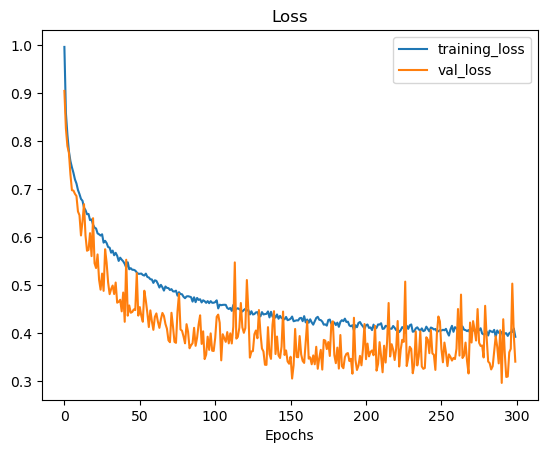

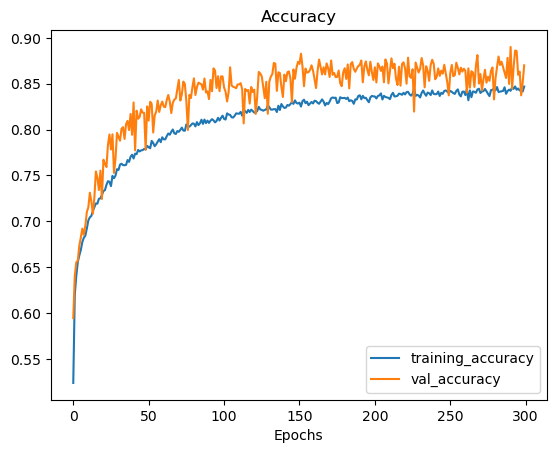

In [10]:
plot_loss_curves(cnn_model.history)

In [11]:
# Import model

from tensorflow.keras.models import load_model
# Load the model
cnn_model = load_model("Modelos/FJSL_Alzheimer_Classification_V2.h5")

In [16]:
# Define Paths
dataset_dir = "val_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 751
Class: Moderate Dementia, Files Found: 73
Class: Non Demented, Files Found: 2250
Class: Very mild Dementia, Files Found: 2059


In [25]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read the image from the path
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image to RGB
    image = tf.image.resize(image, [128, 128])  # Resize to (128, 128)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load and preprocess a list of images
def load_and_preprocess_images(image_paths):
    # Preprocess all images and store them in a list
    images = [preprocess_image(image_path) for image_path in image_paths]
    
    # Stack the images into a single batch (shape: (batch_size, 128, 128, 3))
    images_batch = tf.stack(images)
    
    return images_batch


test_data = load_and_preprocess_images(image_paths)

# Convert labels to NumPy array
#labels = np.array(labels)


In [20]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

161/161 [==============================] - 6s 37ms/step
[0 2 0 ... 3 3 3]
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.90      0.82      0.86       751
 Moderate Dementia       0.00      0.00      0.00        73
      Non Demented       0.90      0.91      0.91      2250
Very mild Dementia       0.86      0.91      0.88      2059

          accuracy                           0.88      5133
         macro avg       0.67      0.66      0.66      5133
      weighted avg       0.87      0.88      0.88      5133



/opt/anaconda3/envs/AAUTIA2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/AAUTIA2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/AAUTIA2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

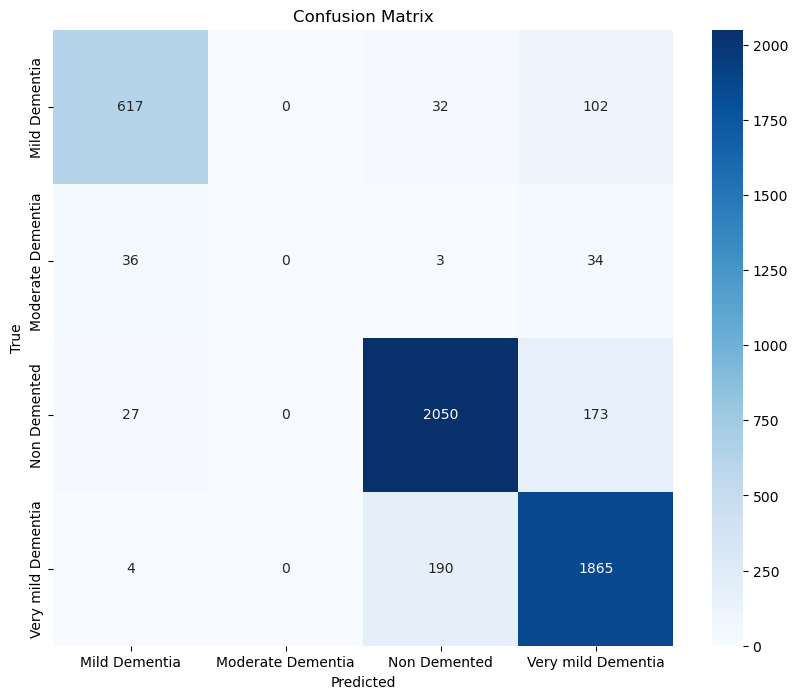

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

y_true = labels
predictions = cnn_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
# Classification Report
class_names = classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()